# LVK O4 sumary

In [2]:
import EPTools
import os, sys
sys.path.append('/Users/liangrunduo/EP/Tools/')
from astropy.cosmology import Planck18
from astropy.coordinates import SkyCoord
from EPTools.utils import *
import numpy as np
import matplotlib.pyplot as plt
from ligo.skymap.io.fits import read_sky_map, write_sky_map
import ligo.skymap.postprocess as postprocess
from astropy.io.fits import writeto
from toolkit import *
import subprocess
save_dir = '/Users/liangrunduo/EP/GW/'
client = GraceDb()
home_dir = os.getcwd()

## Download All Superevent Skymaps in O4

In [2]:
O4_messages = retrive_gracedb(query='is_public: True runid: O4 far < 3.17e-8 ')  #We retrieve data with FAR < 1 per yr
print(O4_messages['S241102br'])

{'alert_type': 'UPDATE', 'time_created': '2024-11-03T20:04:48Z', 'superevent_id': 'S241102br', 'urls': {'gracedb': 'https://gracedb.ligo.org/superevents/S241102br/view/'}, 'event': {'significant': True, 'time': '2024-11-02T12:40:58.788Z', 'far': 1.14177774199959e-41, 'instruments': ['H1', 'L1', 'V1'], 'group': 'CBC', 'pipeline': 'gstlal', 'search': 'AllSky', 'properties': {'HasNS': 0.0, 'HasRemnant': 0.0, 'HasMassGap': 0.0002537427048972342}, 'classification': {'BBH': 0.9921335082053966, 'BNS': 3.5277724299018267e-94, 'NSBH': 0.007866491794603327, 'Terrestrial': 1.1102230246251565e-16}, 'duration': None, 'central_frequency': None, 'skymap': 'U0lNUExFICA9ICAgICAgICAgICAgICAgICAgICBUIC8gY29uZm9ybXMgdG8gRklUUyBzdGFuZGFyZCAgICAgICAgICAgICAgICAgICAgICBCSVRQSVggID0gICAgICAgICAgICAgICAgICAgIDggLyBhcnJheSBkYXRhIHR5cGUgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIE5BWElTICAgPSAgICAgICAgICAgICAgICAgICAgMCAvIG51bWJlciBvZiBhcnJheSBkaW1lbnNpb25zICAgICAgICAgICAgICAgICAgICAgRVhURU5EICA9ICAgICAgICAgICAgIC

In [5]:
print(O4_messages['S241102br']['event']['classification'])

{'BBH': 0.9921335082053966, 'BNS': 3.5277724299018267e-94, 'NSBH': 0.007866491794603327, 'Terrestrial': 1.1102230246251565e-16}


In [4]:
'''If you want to get A90 and distance information, 
you should download skymap for each event and process it. 
There is a load_skymap() in my toolkit in R930'''
save_dir = '/Users/liangrunduo/EP/GW/'
client = GraceDb()
for event_id in O4_messages:
    try:
        filename = 'Bilby.offline0.multiorder.fits'
        r = client.files(event_id,'Bilby.offline0.multiorder.fits')
    except:
        try:
            filename = 'Bilby.multiorder.fits'
            r = client.files(event_id,'Bilby.multiorder.fits')
        except:
            try:
                filename = 'bayestar.multiorder.fits'
                r = client.files(event_id,'bayestar.multiorder.fits')
            except:
                print('Retraction: {}'.format(event_id))
                continue
            
    command = ['wget','-O',save_dir+event_id+'_skymap.fits',
               'https://gracedb.ligo.org/api/superevents/{}/files/{}'.format(event_id,filename)]
    output = subprocess.run(command,capture_output=True,text=True)
                

CompletedProcess(args=['wget', '-O', '/Users/liangrunduo/EP/GW/S241102cy_skymap.fits', 'https://gracedb.ligo.org/api/superevents/S241102cy/files/Bilby.offline0.multiorder.fits'], returncode=0, stdout='', stderr='--2024-11-06 11:38:04--  https://gracedb.ligo.org/api/superevents/S241102cy/files/Bilby.offline0.multiorder.fits\n正在解析主机 gracedb.ligo.org (gracedb.ligo.org)... 100.21.214.239, 52.25.57.90, 44.225.177.158\n正在连接 gracedb.ligo.org (gracedb.ligo.org)|100.21.214.239|:443... 已连接。\n已发出 HTTP 请求，正在等待回应... 200 OK\n长度：869760 (849K) [image/fits]\n正在保存至: “/Users/liangrunduo/EP/GW/S241102cy_skymap.fits”\n\n     0K .......... .......... .......... .......... ..........  5%  239K 3s\n    50K .......... .......... .......... .......... .......... 11%  239K 3s\n   100K .......... .......... .......... .......... .......... 17%  121M 2s\n   150K .......... .......... .......... .......... .......... 23%  240K 2s\n   200K .......... .......... .......... .......... .......... 29%  130M 2s\n   250K 

## Process Skymaps

In [2]:
import os
process_area = False
file_list = os.listdir(save_dir)
skymap_data = {}
for filename in file_list:
    indi = filename.split('_')
    event_id = indi[0]
    try:
        skymap, meta = read_sky_map(save_dir+filename,nest=False,distances=True)
        prob = skymap[0]
        if meta['distmean'] < 500:
            skymap_data[event_id] = dict()
            #skymap_data[event_id]['skymap'] = skymap
            skymap_data[event_id]['distmean'] = meta['distmean']
            skymap_data[event_id]['diststd'] = meta['diststd']

            if process_area:
                ra, dec, a, b, pa, area = postprocess.find_ellipse(prob)
                print(event_id+' Dist = {},  A90 = {}'.format(meta['distmean'],area))
                skymap_data[event_id]['A90'] = area
            else:
                print(event_id+' Dist = {}'.format(meta['distmean']))
    except:
        print(filename)
        

S230529ay Dist = 197.180803380434
.DS_Store
S240925n Dist = 322.535141854722
S230814ah Dist = 329.5829480845621
S241102br Dist = 364.0146333412772
S240429an Dist = 13.662503404808366
S230627c Dist = 290.9508721767887
S240422ed Dist = 188.18928254533978
S241011k Dist = 212.20409963130336
S230810af Dist = 100.4032777442462
S230830b Dist = 214.0960402190468


In [ ]:
import glob
os.chdir(save_dir)
result = glob.glob('*.{}'.format('fits'))

10


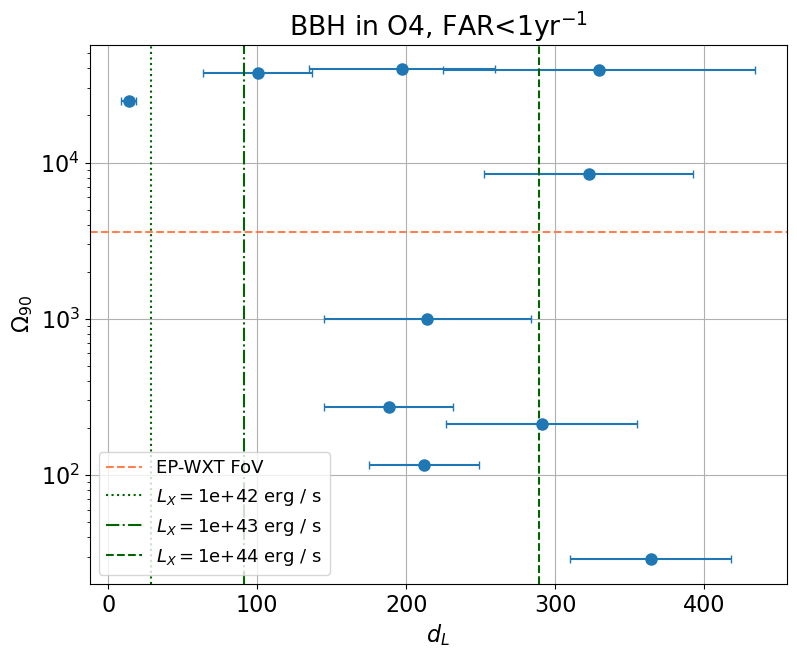

In [65]:
flare_lums = [1e42,1e43,1e44]*u.erg/u.s
flare_flx = 1e-11*u.erg/u.s/(u.cm)**2
flare_dist =np.sqrt(flare_lums/(4*pi*flare_flx)).to(u.Mpc)
lss = [':','-.','--']

plt.rcParams["font.size"] = 16
fig, ax = plt.subplots(figsize=(9,7),dpi=100)
dist_list = np.array([skymap_data[item]['distmean'] for item in skymap_data.keys()])
disterr_list = np.array([skymap_data[item]['diststd'] for item in skymap_data.keys()])
A90_list = np.array([skymap_data[item]['A90'] for item in skymap_data.keys()])
label_list = list(skymap_data.keys())
ax.errorbar(x=dist_list,y=A90_list,xerr=disterr_list,fmt='o',markersize=8,capsize=3)
ax.axhline(y=3600,xmin=0,xmax=500,color='coral',ls='--',label='EP-WXT FoV')
for i,flare_dist_i in enumerate(flare_dist): 
    ax.axvline(x=flare_dist_i.value,ymin=0,ymax=1e4,color='darkgreen',ls=lss[i],
               label='$L_{X} = $'+'{:.0e}'.format(flare_lums[i]))
ax.grid()
ax.set_yscale('log')
ax.set_ylabel(r'$\Omega_{90}$')
ax.set_xlabel(r'$d_{L}$')
ax.legend(fontsize=13)
ax.set_title('BBH in O4, FAR<'+r'$1 \mathrm{yr}^{-1}$')
print(len(list(skymap_data.keys())))
plt.savefig('/Users/liangrunduo/EP/Results/BBH_O4_summary.pdf',dpi=300)

## Process EP Plan

In [39]:
from EPTools.gw_em import *
register_epband()

def make_EPPlan(filename:str,instrument:str):
    zp = 30.
    pointings = pd.read_csv(filename)

    try:
        register_epband()
    except:
        print('EP Mock Band was registered')
        
    if instrument == 'WXT':
        width, height = np.sqrt(75), np.sqrt(75)
        band = 'epwxt'
        ra = pointings['Pointing RA']
        dec = pointings['Pointing Dec']
        expo = pointings['Exposure (s)']
        time = Time(list(pointings['Obs Start Time (UTC)'].to_numpy()),format='isot', scale='utc').mjd

    elif instrument == 'FXT':
        width, height = 1, 1
        band = 'epfxt'
        ra = pointings['Obj_RA']
        dec = pointings['Obj_Dec']
        expo = pointings['Exposure Time (s)']
        time = Time(list(pointings['Obs Start Time (UTC) '].to_numpy()), format='iso', scale='utc').mjd
    

    mAB = EPTools.gw_em.EPexpo2mAB(expo,instrument=instrument)
    print(mAB)
    zp = zp * np.ones(ra.shape)
    band = [band] * len(ra)
    skynoise = 10**(-0.4 * (mAB - zp)) / 5

    plan = simsurvey.SurveyPlan(time=time,
                                band=band,
                                ra=ra,
                                dec=dec,
                                skynoise=skynoise,
                                obs_ccd=None,
                                zp=zp,
                                comment=[' ']*len(ra),
                                height=height,
                                width=width
                                )
    
    return plan

event_name = 'S240422ed'
file_root = '/Users/liangrunduo/EP/GW/Plans/{}/'.format(event_name)
#file_root = '/Users/liangrunduo/Desktop/Aujust/NAOC/EP/GW/Plans/'
wxt_fname = 'wxt_obs_{}.csv'.format(event_name)
fxt_fname = 'fxt_obs_{}.csv'.format(event_name)



# wxtplan = make_EPPlan(file_root+wxt_fname,instrument='WXT')
# with open(file_root+'{}_WXT_plan.pkl'.format(event_name),'wb') as f:
#     pickle.dump(wxtplan,f,protocol=pickle.HIGHEST_PROTOCOL)
#     f.close()

fxtplan = make_EPPlan(file_root+fxt_fname,instrument='FXT')
with open(file_root+'{}_FXT_plan.pkl'.format(event_name),'wb') as f:
    pickle.dump(fxtplan,f,protocol=pickle.HIGHEST_PROTOCOL)
    f.close()

fxtplan.pointings

0      27.948800
1      27.948802
2      27.964047
3      27.964049
4      27.999599
         ...    
423    29.337432
424    29.614953
425    29.614951
426    29.505060
427    29.505601
Name: Exposure Time (s), Length: 428, dtype: float64


time,band,zp,skynoise,RA,Dec,field,ccd,comment
float64,str5,float64,float64,float64,float64,float64,float64,str1
60426.38579861111,epfxt,30.0,1.3228479759827096,124.404,-31.2167,nan,nan,
60426.38579861111,epfxt,30.0,1.3228452257140886,124.404,-31.2167,nan,nan,
60426.381585648145,epfxt,30.0,1.3044013030836776,126.61,-27.3603992,nan,nan,
60426.381585648145,epfxt,30.0,1.304398603839815,126.61,-27.3603992,nan,nan,
60426.376979166664,epfxt,30.0,1.262380594218309,121.174,-26.9703007,nan,nan,
60426.376979166664,epfxt,30.0,1.2623779963163415,121.174,-26.9703007,nan,nan,
60426.37278935185,epfxt,30.0,1.2736330028142482,120.772,-26.2001991,nan,nan,
60426.37278935185,epfxt,30.0,1.2736303787465686,120.772,-26.2001991,nan,nan,
60426.368252314816,epfxt,30.0,1.2327878921923419,122.775,-23.6891994,nan,nan,


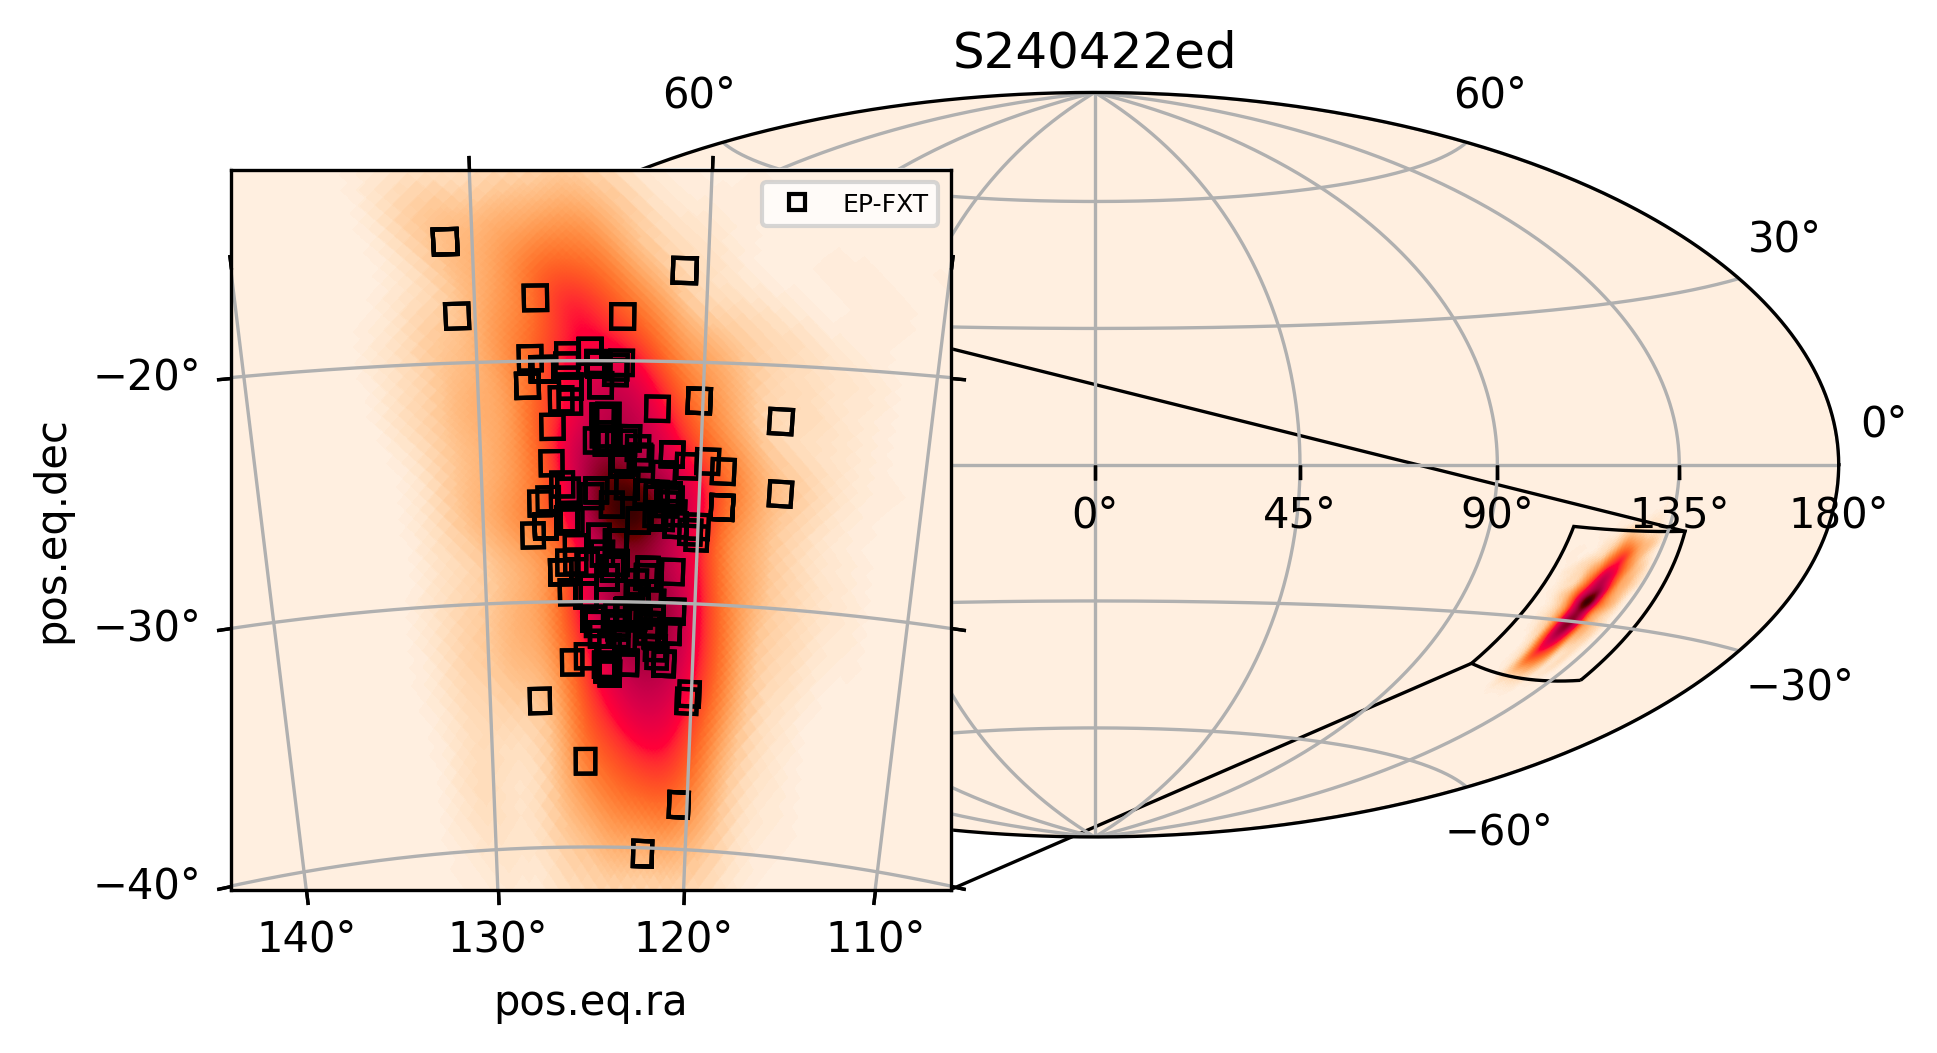

In [81]:
'Plot skymap and EP footprint'

from matplotlib.lines import Line2D
import ligo.skymap.plot
from matplotlib import pyplot as plt
import astropy.units as u
from matplotlib.patches import Rectangle

fig = plt.figure(dpi=300)
m, meta = ligo.skymap.io.fits.read_sky_map('/Users/liangrunduo/EP/GW/Bilby_offline_S240422ed.fits',nest=False,distances=True)
ax_globe = plt.axes(projection='geo aitoff')
ax_zoom_rect = plt.axes(
    [0.0, 0.2, 0.5, 0.5],
    projection='astro degrees zoom',
    center='125d -27d',
    radius='15 deg')
# ax = plt.axes(projection='astro zoom',
#               center='8h25min -28d', radius=20*u.deg, rotate='0 deg')
ax_globe.grid()
ax_zoom_rect.grid()
ax_globe.imshow_hpx(m[0], cmap='cylon')
ax_zoom_rect.imshow_hpx(m[0], cmap='cylon')



ax_globe.mark_inset_axes(ax_zoom_rect)
ax_globe.connect_inset_axes(ax_zoom_rect, 'upper left')
ax_globe.connect_inset_axes(ax_zoom_rect, 'lower right')


ra, dec = fxtplan.pointings['RA'], fxtplan.pointings['Dec']
for i in range(len(ra)):
    patch = Rectangle((ra[i],dec[i]),width=1,height=1,fill=False,color='k',transform=ax_zoom_rect.get_transform('world'))
    ax_zoom_rect.add_patch(patch)

ax_globe.set_title(event_name)
l = Line2D([],[],marker='s',color='k',markersize=4,linestyle='',fillstyle='none')
ax_zoom_rect.legend(handles=[l],labels=['EP-FXT'],fontsize=6)
plt.savefig('/Users/liangrunduo/EP/Results/S240422ed_EP_footprint.pdf',dpi=300)

In [53]:
ax_zoom_rect.get_xlim

<bound method _AxesBase.get_xlim of <AstroDegreesZoomAxes: >>